<a href="https://colab.research.google.com/github/Vishal8500/Job-Market-Analysis-using-Big-Data-tools/blob/main/Job_Market_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:
!curl -I https://www.google.com


HTTP/2 200 
content-type: text/html; charset=ISO-8859-1
content-security-policy-report-only: object-src 'none';base-uri 'self';script-src 'nonce-yxkj2mm0gwcNq5q8d1XDpA' 'strict-dynamic' 'report-sample' 'unsafe-eval' 'unsafe-inline' https: http:;report-uri https://csp.withgoogle.com/csp/gws/other-hp
accept-ch: Sec-CH-Prefers-Color-Scheme
p3p: CP="This is not a P3P policy! See g.co/p3phelp for more info."
date: Sat, 29 Mar 2025 17:20:00 GMT
server: gws
x-xss-protection: 0
x-frame-options: SAMEORIGIN
expires: Sat, 29 Mar 2025 17:20:00 GMT
cache-control: private
set-cookie: AEC=AVcja2fIG_9U14-UiBNOCnFvYjK3dW-RYvy2q7kMlvnqy3bSgyDzbRSESzQ; expires=Thu, 25-Sep-2025 17:20:00 GMT; path=/; domain=.google.com; Secure; HttpOnly; SameSite=lax
set-cookie: NID=522=2XIj5O3ZtRiee1Ku2uUUaI4TzNgYpUvMw2DsI5NC3ENPmpBkhSwP4qRz2KztlHvVB1fWq6ZV5flnP6GyeT1k1ZDhgLqOJ2UI8vWjRITcrdcho6B4xebjiJjgwP-mNY_9y5s-3mKrFZDaeJmFh1A8BmqXgGpGu94zdLEXlicQTY14epOtxQqsfhK7P4qsQr4duOSFNIzaOqRPokr4um8; expires=Sun, 28-Sep-2025 17

In [ ]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz


In [ ]:
!ls -lh


total 384M
-rw-r--r-- 1 root root 999K Mar 29 17:21 indeed_results.csv
drwxr-xr-x 1 root root 4.0K Mar 24 13:34 sample_data
-rw-r--r-- 1 root root 383M Mar 29 17:28 spark-3.5.5-bin-hadoop3.tgz


In [ ]:
!tar xf spark-3.5.5-bin-hadoop3.tgz


In [ ]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("SalaryPrediction").getOrCreate()

# Print Spark version
print(f"Spark version: {spark.version}")

Spark version: 3.5.5


In [ ]:

!pip install pyspark

In [ ]:
# Set up environment variables for PySpark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark"

# Initialize PySpark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark
spark = SparkSession.builder.appName("SalaryPrediction").getOrCreate()

# Assuming the uploaded file is 'indeed_results.csv'
file_path = "/content/indeed_results.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Rename 'salary_avg' to 'label'
df = df.withColumnRenamed("salary_avg", "label")

# Define categorical columns
categorical_cols = ["title", "search_city"]

# Apply StringIndexer to categorical columns
indexers = {}
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_index").fit(df)
    df = indexer.transform(df)
    indexers[col] = indexer

# Assemble features
feature_cols = [f"{col}_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Split dataset
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train Linear Regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="label")
lr_model = lr.fit(train_df)

# Train Random Forest model
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_df)

# Evaluate both models
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Evaluate Linear Regression
lr_predictions = lr_model.transform(test_df)
lr_rmse = evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")

# Evaluate Random Forest
rf_predictions = rf_model.transform(test_df)
rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest RMSE: {rf_rmse}")

# Function to predict salary based on user input (using Random Forest by default)
def predict_salary(job_title: str, search_city: str, model="random_forest"):
    # Create a DataFrame for user input
    input_df = spark.createDataFrame([(job_title, search_city)], ["title", "search_city"])

    # Apply transformations
    for col in categorical_cols:
        if col in indexers:
            input_df = indexers[col].transform(input_df)

    input_df = assembler.transform(input_df)
    input_df = scaler_model.transform(input_df)

    # Predict using the selected model
    if model == "linear_regression":
        predictions = lr_model.transform(input_df)
    else:
        predictions = rf_model.transform(input_df)

    if predictions.count() > 0:  # Ensure predictions exist
        predicted_salary = predictions.select("prediction").collect()[0][0]
        return predicted_salary
    else:
        return "Prediction failed. Input data might be incompatible."

# Example usage
user_job_title = input("Enter job title: ")
user_location = input("Enter location: ")

predicted_salary = predict_salary(user_job_title, user_location, model="random_forest")
print(f"Predicted Average Salary (Random Forest): {predicted_salary}")


Linear Regression RMSE: 31936.866409139915
Random Forest RMSE: 28718.21718479599
Enter job title: Building Automation Systems Engineer
Enter location: Dallas
Predicted Average Salary (Random Forest): 89308.01315485113


In [ ]:
# Average salary by city
city_salary_trend = df.groupBy("search_city").avg("label").withColumnRenamed("avg(label)", "avg_salary")

# Average salary by job title
job_salary_trend = df.groupBy("title").avg("label").withColumnRenamed("avg(label)", "avg_salary")


In [ ]:
# Convert city salary trend to Pandas
city_salary_pandas = city_salary_trend.toPandas()

# Convert job salary trend to Pandas
job_salary_pandas = job_salary_trend.toPandas()


<ipython-input-25-8c8a6834294e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_salary_pandas, x="search_city", y="avg_salary", palette="viridis")


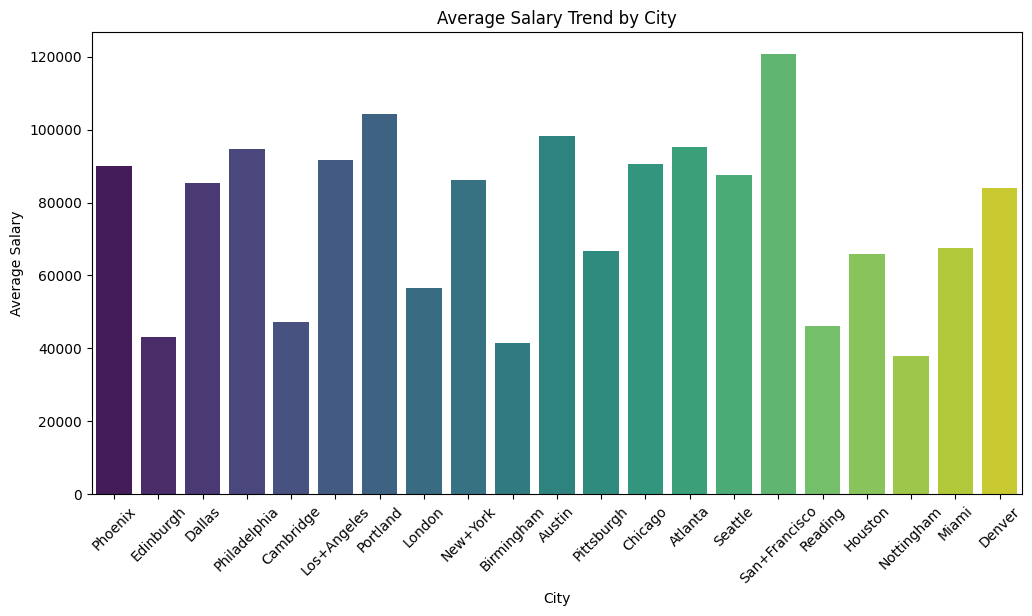

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot salary trend among cities
plt.figure(figsize=(12, 6))
sns.barplot(data=city_salary_pandas, x="search_city", y="avg_salary", palette="viridis")
plt.title("Average Salary Trend by City")
plt.xlabel("City")
plt.ylabel("Average Salary")
plt.xticks(rotation=45)
plt.show()




In [ ]:
# Count the occurrences of each job title
job_count = df.groupBy("title").count().withColumnRenamed("count", "job_frequency")

# Get the top 10 most common job titles
top_jobs = job_count.orderBy("job_frequency", ascending=False).limit(10)

# Join with the original dataset to calculate average salary for these jobs
top_jobs_with_salary = df.join(top_jobs, on="title", how="inner") \
                         .groupBy("title").agg({"label": "avg"}) \
                         .withColumnRenamed("avg(label)", "avg_salary")


In [ ]:
# Convert to Pandas for visualization
top_jobs_pandas = top_jobs_with_salary.toPandas()


<ipython-input-21-12a41c8dac18>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_jobs_pandas, x="title", y="avg_salary", palette="coolwarm")


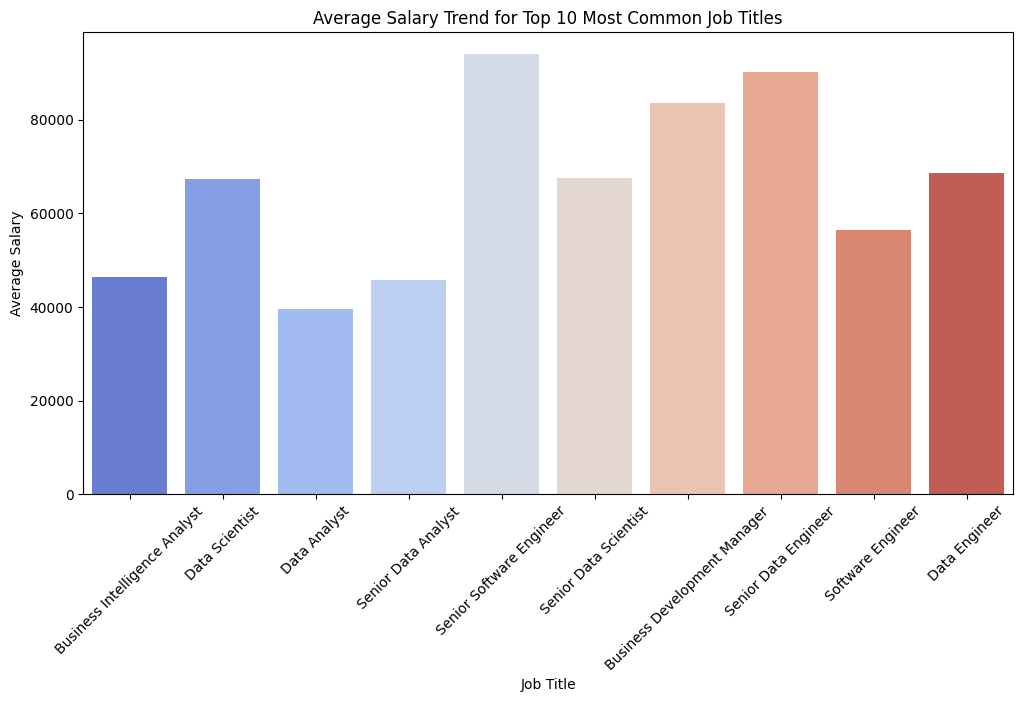

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot salary trend for top 10 jobs
plt.figure(figsize=(12, 6))
sns.barplot(data=top_jobs_pandas, x="title", y="avg_salary", palette="coolwarm")
plt.title("Average Salary Trend for Top 10 Most Common Job Titles")
plt.xlabel("Job Title")
plt.ylabel("Average Salary")
plt.xticks(rotation=45)
plt.show()
